 #  Writing like the Shakespeare




Task is to generate Shakespeare poems. Instead of learning from a dataset of Dinosaur names you can use a collection of Shakespearian poems. Using LSTM cells, you can learn longer term dependencies that span many characters in the text--e.g., where a character appearing somewhere a sequence can influence what should be a different character much much later in ths sequence. These long term dependencies were less important with dinosaur names, since the names were quite short. 

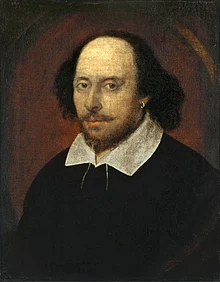

<caption><center> Let's become poets! </center></caption>


## Language Modeling
Our goal is to build a Language Model using a Recurrent Neural Network. Here’s what that means. Let’s say we have sentence of m words. A language model allows us to predict the probability of observing the sentence (in a given dataset) as:

\begin{aligned}  P(w_1,...,w_m) = \prod_{i=1}^{m} P(w_i \mid w_1,..., w_{i-1})  \end{aligned}

In words, the probability of a sentence is the product of probabilities of each word given the words that came before it. So, the probability of the sentence “He went to buy some chocolate” would be the probability of “chocolate” given “He went to buy some”, multiplied by the probability of “some” given “He went to buy”, and so on.

## Character Based Language Model
Here we build a character lebel language model to teach a sequence model to output Shakespeare's style of poetry.
Ref - https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/

In [26]:
import numpy as np
import sys
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation

Load the text file containing Shakespeare's sonnet. 

In [2]:
with open("shakespeare_sonnet.txt") as corpus_file:
    corpus = corpus_file.read().lower()
print("Loaded a corpus of" , len(corpus), "characters")

Loaded a corpus of 94212 characters


In [12]:
chars = sorted(list(set(corpus)))
num_chars = len(chars)
vocab = len(chars)
print("Our corpus contains",num_chars,"unique characters.")

Our corpus contains 38 unique characters.


 ### Prepare the data for modeling by the neural network
 We cannot model the characters directly, instead we must convert the characters to integers. Get a unique identifier for each char in the corpus, then make some dicts to ease encoding and decoding.

In [4]:
encoding =  dict((c,i) for i, c in enumerate(chars))

There is a lot of flexibility in how you choose to break up the text and expose it to the network during training.

We will split the sonnet text up into subsequences with a fixed length of 100 characters, an arbitrary length. We could just as easily split the data up by sentences and pad the shorter sequences and truncate the longer ones.

##### NOTE-
Each training pattern of the network is comprised of 100 time steps of one character (X) followed by one character output (y). When creating these sequences, we slide this window along the whole book one character at a time, allowing each character a chance to be learned from the 100 characters that preceded it (except the first 100 characters of course).

In [5]:
sentence_length = 100
skip = 1
X_data = []
y_data = []
for i in range (0, len(corpus) - sentence_length, skip):
    sentence  = corpus[i:i + sentence_length]
    next_char = corpus[i   + sentence_length]
    X_data.append([encoding[char] for char in sentence])
    y_data.append(encoding[next_char])

num_sentences = len(X_data)
print("Sliced our corpus into {0} sentences of length {1}".format(num_sentences, sentence_length))

Sliced our corpus into 94112 sentences of length 100


Now that we have prepared our training data we need to transform it so that it is suitable for use with Keras.

First we must transform the list of input sequences into the form [samples, time steps, features] expected by an LSTM network.


Next we need to rescale the integers to the range 0-to-1 to make the patterns easier to learn by the LSTM network that uses the sigmoid activation function by default.

Finally, we need to convert the output patterns (single characters converted to integers) into a one hot encoding. This is so that we can configure the network to predict the probability of each of the 38 different characters in the vocabulary (an easier representation) rather than trying to force it to predict precisely the next character. Each y value is converted into a sparse vector with a length of 38, full of zeros except with a 1 in the column for the letter (integer) that the pattern represents.

In [6]:
X = np.zeros((num_sentences, sentence_length, num_chars), dtype=np.bool)
y = np.zeros((num_sentences, num_chars), dtype=np.bool)

In [7]:
for i, sentence in enumerate(X_data):
    for t, encoded_char in enumerate(sentence):
        X[i, t, encoded_char] = 1
    y[i, y_data[i]] = 1

In [8]:
print("y Dimension: ",(y.shape, num_sentences, len(chars)))
print("x Dimension: ",(X.shape, sentence_length))

y Dimension:  ((94112, 38), 94112, 38)
x Dimension:  ((94112, 100, 38), 100)


###### LSTM model


Here we define a single hidden LSTM layer with 256 memory units. The network uses dropout with a probability of 20. 

The output layer is a Dense layer using the softmax activation function to output a probability prediction for each of the 38 characters between 0 and 1.

*The problem is really a single character classification problem with 38 classes and as such is defined as optimizing the log loss (cross entropy), here using the ADAM optimization algorithm for speed.*

In [9]:
model = Sequential()
model.add(LSTM(256, input_shape=(sentence_length, num_chars)))
model.add(Dense(num_chars))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [10]:
from keras.callbacks import ModelCheckpoint
filepath="saved_models/weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks = [checkpoint]

In [11]:
model.fit(X, y, epochs=30, batch_size=400, callbacks=callbacks)

Epoch 1/30
94112/94112 [==============================] - 135s 1ms/step - loss: 2.8266

Epoch 00001: loss improved from inf to 2.82664, saving model to saved_models/weights-improvement-01-2.8266.hdf5
Epoch 2/30
94112/94112 [==============================] - 120s 1ms/step - loss: 2.2752

Epoch 00002: loss improved from 2.82664 to 2.27518, saving model to saved_models/weights-improvement-02-2.2752.hdf5
Epoch 3/30
94112/94112 [==============================] - 126s 1ms/step - loss: 2.1124

Epoch 00003: loss improved from 2.27518 to 2.11238, saving model to saved_models/weights-improvement-03-2.1124.hdf5
Epoch 4/30
94112/94112 [==============================] - 127s 1ms/step - loss: 2.0011

Epoch 00004: loss improved from 2.11238 to 2.00107, saving model to saved_models/weights-improvement-04-2.0011.hdf5
Epoch 5/30
94112/94112 [==============================] - 135s 1ms/step - loss: 1.9093

Epoch 00005: loss improved from 2.00107 to 1.90935, saving model to saved_models/weights-improvement

##### Why there is no test dataset?
We are modeling the entire training dataset to learn the probability of each character in a sequence since we are not interested in the most accurate (classification accuracy) model of the training dataset. This would be a model that predicts each character in the training dataset perfectly.


Instead we are interested in a generalization of the dataset that minimizes the chosen loss function. We are seeking a balance between generalization and overfitting but short of memorization.

### Generating Text with an LSTM Network

In [14]:
filename = "saved_models/weights-improvement-30-0.8641.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [15]:
decoding =  dict((i,c) for i, c in enumerate(chars))

The simplest way to use the Keras LSTM model to make predictions is to first start off with a seed sequence as input, generate the next character then update the seed sequence to add the generated character on the end and trim off the first character. 

This process is repeated for as long as we want to predict new characters (e.g. a sequence of 1,000 characters in length).

In [63]:
from random import randint
seed = randint(0, len(corpus) - sentence_length)
pattern = corpus[seed:seed + sentence_length]

In [64]:
X = np.zeros((1, sentence_length, num_chars), dtype=np.bool)

In [65]:
pattern

' your truth.\n\nnot marble, nor the gilded monuments\nof princes shall outlive this powerful rhyme,\nbut'

In [68]:
generated_text = ""
for i, character in enumerate("your truth"):
    X[0, i, encoding[character]] = 1
    for i in range(50):
        prediction = np.argmax(model.predict(X, verbose=0))

        generated_text += decoding[prediction]

        activations = np.zeros((1, 1, num_chars), dtype=np.bool)
        activations[0, 0, prediction] = 1
        X = np.concatenate((X[:, 1:, :], activations), axis=1)

In [69]:
generated_text

"wn sweet forbe.\n\n\n\no now that me not be bester the deathst sport,\nbut then bether's receld of my writked shame,\nbut be the beauty of the world all wit,\nwhith not to greet it i live thee for wor,\nfor truth and often seased every herr\nwhor thy concersess i straingats should be thee,\nwho all mecheaved weer from you be but seed,\nto see a worth of soul shall i be thought,\nto live i say the trings to the summor grows\nwhich say to his scorivige and crount of hist,\nin still the world with this such swee"